In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [10]:
class QRDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.loaded_images_count = 0  # Counter for successfully loaded images

    def apply_clahe(self, image_np):
        """Apply CLAHE to a grayscale image."""
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(gray)

    def apply_lbp(self, gray_image):
        """Compute Local Binary Pattern (LBP)."""
        lbp = cv2.Laplacian(gray_image, cv2.CV_64F)  # Use Laplacian for LBP-like feature
        return lbp.astype(np.uint8)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            # Load image as numpy array
            image = Image.open(image_path).convert("RGB")
            image_np = np.array(image)

            # Apply CLAHE and LBP
            clahe_image = self.apply_clahe(image_np)
            lbp_image = self.apply_lbp(clahe_image)

            # Stack CLAHE and LBP as 3-channel input
            combined_image = np.stack([clahe_image, lbp_image, lbp_image], axis=-1)

            # Convert back to PIL Image for further transformations
            combined_image = Image.fromarray(combined_image)

            # Apply transformations
            if self.transform:
                combined_image = self.transform(combined_image)

            self.loaded_images_count += 1  # Increment the counter for successfully loaded images
            return combined_image, label

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None, None


In [11]:
def mixup_data(x, y, alpha=0.4):
    """MixUp augmentation."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Criterion for MixUp."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [12]:
from google.colab import drive
import os
from sklearn.model_selection import train_test_split

# ===========================
# Mount Google Drive
# ===========================
drive.mount('/content/drive')

# Specify the path to your dataset in Google Drive
data_dir = "/content/drive/My Drive/Colab Notebooks/Computer_Vision_Final_Project"

# ===========================
# Data Preparation Function
# ===========================
def get_data(data_dir):
    """Fetch image paths and labels."""
    image_paths, labels, label_mapping = [], [], {}
    label_counter = 0

    for label_name in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label_name)

        # Check if it's a directory
        if not os.path.isdir(label_dir):
            continue

        # Map label name to numerical index
        if label_name not in label_mapping:
            label_mapping[label_name] = label_counter
            label_counter += 1

        # Collect image paths
        for file in os.listdir(label_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(label_dir, file))
                labels.append(label_mapping[label_name])

    return image_paths, labels

# ===========================
# Load Data
# ===========================
all_image_paths, all_labels = get_data(data_dir)

# ===========================
# Split Data
# ===========================
# Calculate required test size
total_samples = len(all_image_paths)
desired_test_size = 60 / total_samples

# Split the dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=desired_test_size, random_state=42, stratify=all_labels
)


print("Number of training samples:", len(train_paths))
print("Number of testing samples:", len(test_paths))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of training samples: 502
Number of testing samples: 60


Total images loaded in train dataset: 502
Total images loaded in test dataset: 60


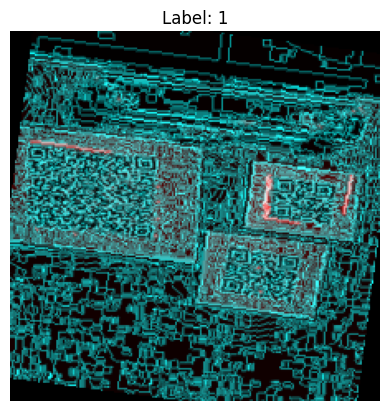

In [13]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Datasets
train_dataset = QRDataset(train_paths, train_labels, transform=train_transform)
test_dataset = QRDataset(test_paths, test_labels, transform=test_transform)

print(f"Total images loaded in train dataset: {len(train_dataset)}")
print(f"Total images loaded in test dataset: {len(test_dataset)}")

# Visualize Sample Data
sample_image, sample_label = train_dataset[0]
plt.imshow(sample_image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # De-normalize
plt.title(f"Label: {sample_label}")
plt.axis("off")
plt.show()


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)

# Modify the classifier dynamically
num_features = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(set(train_labels)))
)
model = model.to(device)


In [15]:
# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

if __name__ == '__main__':
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
# Training Loop
best_acc = 0.0
train_accuracies, test_accuracies = [], []

for epoch in range(20):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        images, labels = images.to(device), labels.to(device)
        mixed_images, targets_a, targets_b, lam = mixup_data(images, labels)

        optimizer.zero_grad()
        outputs = model(mixed_images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item()
        total += labels.size(0)

    train_acc = 100. * correct / total
    train_accuracies.append(train_acc)
    scheduler.step()
    print(f"Epoch [{epoch+1}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

    model.eval()  # Set the model to evaluation mode
correct_preds = 0
total_preds = 0
total_loss = 0

model.eval()  # Set the model to evaluation mode
correct_preds = 0
total_preds = 0
total_loss = 0

with torch.no_grad():
    for images, labels in test_loader:  # Unpack only two values
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)  # Use images only
        loss = criterion(outputs, labels)

        # Calculate loss and predictions
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

# Calculate final loss and accuracy
final_test_loss = total_loss / len(test_loader)
final_test_accuracy = 100 * correct_preds / total_preds

# Print results
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")
print(f"Correct Predictions: {correct_preds}, Total Samples: {total_preds}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/20: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


Epoch [1], Loss: 0.5195, Accuracy: 78.04%


Epoch 2/20: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Epoch [2], Loss: 0.4353, Accuracy: 89.24%


Epoch 3/20: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]


Epoch [3], Loss: 0.4199, Accuracy: 89.24%


Epoch 4/20: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]


Epoch [4], Loss: 0.4156, Accuracy: 89.24%


Epoch 5/20: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


Epoch [5], Loss: 0.4163, Accuracy: 89.24%


Epoch 6/20: 100%|██████████| 16/16 [00:07<00:00,  2.19it/s]


Epoch [6], Loss: 0.4158, Accuracy: 89.24%


Epoch 7/20: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]


Epoch [7], Loss: 0.4076, Accuracy: 89.24%


Epoch 8/20: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Epoch [8], Loss: 0.4094, Accuracy: 89.24%


Epoch 9/20: 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


Epoch [9], Loss: 0.4090, Accuracy: 89.24%


Epoch 10/20: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]


Epoch [10], Loss: 0.4083, Accuracy: 89.24%


Epoch 11/20: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Epoch [11], Loss: 0.4208, Accuracy: 89.24%


Epoch 12/20: 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]


Epoch [12], Loss: 0.4098, Accuracy: 89.24%


Epoch 13/20: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


Epoch [13], Loss: 0.4159, Accuracy: 89.24%


Epoch 14/20: 100%|██████████| 16/16 [00:08<00:00,  1.91it/s]


Epoch [14], Loss: 0.4073, Accuracy: 89.24%


Epoch 15/20: 100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


Epoch [15], Loss: 0.4094, Accuracy: 89.24%


Epoch 16/20: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Epoch [16], Loss: 0.4110, Accuracy: 89.24%


Epoch 17/20: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


Epoch [17], Loss: 0.4073, Accuracy: 89.24%


Epoch 18/20: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch [18], Loss: 0.4041, Accuracy: 89.24%


Epoch 19/20: 100%|██████████| 16/16 [00:08<00:00,  1.85it/s]


Epoch [19], Loss: 0.4093, Accuracy: 89.24%


Epoch 20/20: 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

Epoch [20], Loss: 0.4105, Accuracy: 89.24%


Final Test Loss: 0.4180
Final Test Accuracy: 90.00%
Correct Predictions: 54, Total Samples: 60
